In [18]:
import gzip
import json
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import Image

In [2]:
def readFile(filename):
    data = []
    with gzip.open(filename) as f:
        return json.load(f)

In [3]:
reviews = readFile('filtered_data/filtered_reviews.json.gz')
users = readFile('filtered_data/filtered_users.json.gz')
places = readFile('filtered_data/filtered_places.json.gz')

In [4]:
len(reviews)

308846

In [5]:
len(users)

20000

In [6]:
len(places)

218132

### Histogram

In [7]:
reviewsPerUser = defaultdict(set)

for r in reviews:
    placeID, userID = r['gPlusPlaceId'], r['gPlusUserId']
    reviewsPerUser[userID].add((placeID, userID))

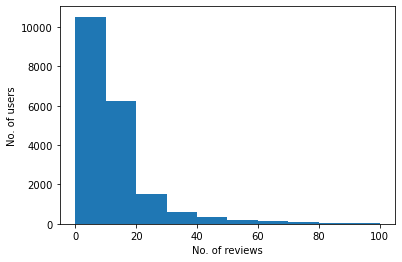

In [8]:
reviewCount = []

for u in reviewsPerUser:
    reviewCount.append(len(reviewsPerUser[u]))
    
plt.hist(reviewCount, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.ylabel('No. of users')
plt.xlabel('No. of reviews')
plt.show()

In [9]:
reviews[0]

{'rating': 5.0,
 'reviewerName': 'Chris Johnson',
 'reviewText': None,
 'categories': ['American Restaurant', 'Bar'],
 'gPlusPlaceId': '103654778391814923896',
 'unixReviewTime': 1311509683,
 'reviewTime': 'Jul 24, 2011',
 'gPlusUserId': '100000524810171549476'}

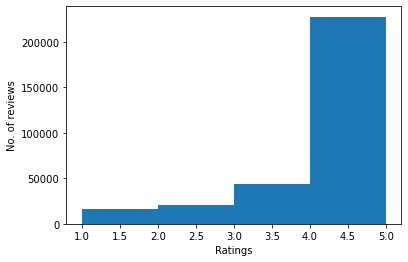

In [10]:
ratingsCount = []
fives = 0

for r in reviews:
    ratingsCount.append(r['rating'])
    if r['rating'] >= 4.0:
        fives += 1
    
plt.hist(ratingsCount, [1, 2, 3, 4, 5])
plt.ylabel('No. of reviews')
plt.xlabel('Ratings')
plt.show()

In [11]:
places[0]

{'name': "T C's Referee Sports Bar",
 'price': '$$',
 'address': ['5322 W 26th St', 'Sioux Falls, SD 57106'],
 'hours': [['Monday', [['11:00 am--10:00 pm']]],
  ['Tuesday', [['11:00 am--10:00 pm']], 1],
  ['Wednesday', [['11:00 am--10:00 pm']]],
  ['Thursday', [['11:00 am--10:00 pm']]],
  ['Friday', [['11:00 am--1:00 am']]],
  ['Saturday', [['11:00 am--1:00 am']]],
  ['Sunday', [['11:00 am--10:00 pm']]]],
 'phone': '(605) 361-2208',
 'closed': False,
 'gPlusPlaceId': '100327153115986850675',
 'gps': [43.529494, -96.792244]}

In [102]:
boundingBox = defaultdict()

with open('box.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if row[0] == '': continue
        boundingBox[row[2]] = (float(row[5]), float(row[7]), float(row[4]), float(row[6]))
        
boundingBox

defaultdict(None,
            {'AL': (30.223334, 35.008028, -88.473227, -84.88908),
             'AK': (51.214183, 71.365162, -179.148909, 179.77847),
             'AS': (-14.548699, -11.046934, -171.089874, -168.1433),
             'AZ': (31.332177, 37.00426, -114.81651, -109.045223),
             'AR': (33.004106, 36.4996, -94.617919, -89.644395),
             'CA': (32.534156, 42.009518, -124.409591, -114.131211),
             'CO': (36.992426, 41.003444, -109.060253, -102.041524),
             'MP': (14.110472, 20.553802, 144.886331, 146.064818),
             'CT': (40.980144, 42.050587, -73.727775, -71.786994),
             'DE': (38.451013, 39.839007, -75.788658, -75.048939),
             'DC': (38.791645, 38.99511, -77.119759, -76.909395),
             'FL': (24.523096, 31.000888, -87.634938, -80.031362),
             'GA': (30.357851, 35.000659, -85.605165, -80.839729),
             'GU': (13.234189, 13.654383, 144.618068, 144.956712),
             'HI': (18.910361, 28.402123, 

In [103]:
placeCoordinates = defaultdict()

for p in places:
    placeCoordinates[p['gPlusPlaceId']] = p['gps']

In [105]:
placeCoordinates['100327153115986850675']

[43.529494, -96.792244]

In [106]:
stateRating = defaultdict()
countRating = defaultdict()

for r in reviews:
    place = r['gPlusPlaceId']
    rating = r['rating']
    if rating > 3: continue
    gps = placeCoordinates[place]
    for b in boundingBox:
        box = boundingBox[b]
        ymin, ymax, xmin, xmax = box[0], box[1], box[2], box[3]
        if gps[0] >= ymin and gps[0] <= ymax and gps[1] >= xmin and gps[1] <= xmax:
            state = b
            if state in stateRating and state in countRating:
                stateRating[state] += rating
                countRating[state] += 1
            else:
                stateRating[state] = rating
                countRating[state] = 1

for state in stateRating:
    stateRating[state] = stateRating[state]/countRating[state]

In [107]:
sorted(countRating.items(), key=lambda x: x[1])

[('SD', 85),
 ('WY', 135),
 ('MT', 138),
 ('ND', 144),
 ('DE', 172),
 ('RI', 175),
 ('VT', 188),
 ('NH', 235),
 ('ME', 283),
 ('NE', 291),
 ('ID', 414),
 ('MS', 468),
 ('AR', 582),
 ('CT', 614),
 ('NM', 650),
 ('IA', 673),
 ('KS', 738),
 ('DC', 777),
 ('OK', 816),
 ('LA', 835),
 ('AL', 867),
 ('WV', 938),
 ('KY', 966),
 ('UT', 1061),
 ('WI', 1080),
 ('TN', 1094),
 ('NV', 1189),
 ('SC', 1384),
 ('IN', 1455),
 ('MN', 1725),
 ('AZ', 1819),
 ('MO', 1950),
 ('OH', 2109),
 ('CO', 2128),
 ('MA', 2396),
 ('GA', 2535),
 ('PA', 2542),
 ('MD', 2856),
 ('OR', 2987),
 ('NC', 3018),
 ('WA', 3328),
 ('VA', 3565),
 ('IL', 4330),
 ('FL', 4822),
 ('MI', 5568),
 ('TX', 8722),
 ('NJ', 9128),
 ('NY', 11364),
 ('CA', 13298)]

In [117]:
stateCodes = []
counts = []

for c in countRating:
    y = (boundingBox[c][0] + boundingBox[c][1])/2
    x = (boundingBox[c][2] + boundingBox[c][3])/2
    stateCodes.append(str(c))
    counts.append(countRating[c])

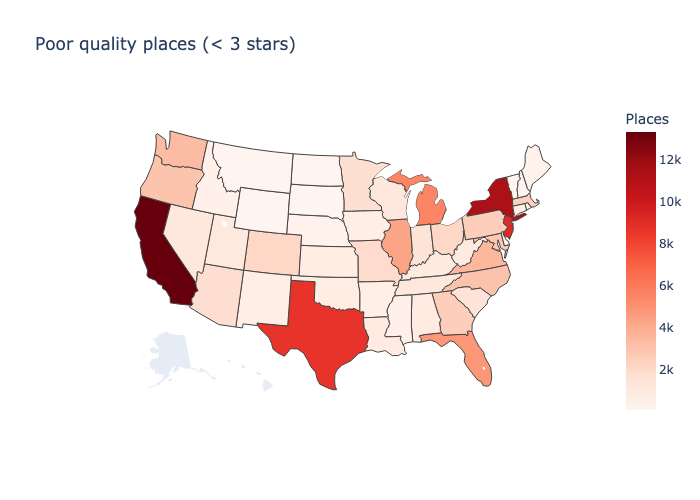

In [118]:
fig = go.Figure(data=go.Choropleth(
    locations=stateCodes, # Spatial coordinates
    z = counts, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Places",
))

fig.update_layout(
    title_text = 'Poor quality places (< 3 stars)',
    geo_scope='usa',
)

imgBytes = fig.to_image(format="png")
Image(imgBytes)